# Plots for differentiation and thermal evolution<a class="anchor" id="top"></a>
For the whole thermal evolution:
+ [temperature](#temp)
+ [% silicate melted](#silicate)
+ [Rayleigh number](#critical-rayleigh)
+ [Stagnant lid thickness](#d0)
+ [Urey ratio](#Urey)


For differentiation stage:
+ [% iron melted](#iron)

For the thermal evolution stage:
+ [temperatures and heat fluxes](#temp-heat)
+ [inner core size and magnetic Reynolds number](#Rem)
+ [magnetic field strength](#B)

## Set-up

In [1]:
#import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from load_info import load_run_info

#scale time to Myr
from parameters import Myr, Tms, Tml, Xs_0 #need to change so import from save file instead

Choose run and whether you want to save figure

In [2]:
run=8
save = False # do you want to save your figures?
conduction = True #does the mantle switch to conduction
path = 'Results_combined/' #path to files

Load npz files for differentiation

In [3]:
npzfile = np.load(f'{path}run_{run}_diff.npz')
Tdiff = npzfile['Tdiff'] 
iron = npzfile['Xfe']
silicate_d = npzfile['Xsi']
tdiff = npzfile['t_diff']
Ra_d = npzfile['Ra']
Ra_crit_d = npzfile['Ra_crit']
d0_diff = npzfile['d0']

Load npz files for thermal evolution

In [4]:
npzfile = np.load(f'{path}run_{run}.npz')
Tc= npzfile['Tc'] 
Tc_conv = npzfile['Tc_conv']
Tcmb = npzfile['Tcmb']
Tm_mid = npzfile['Tm_mid']
Tm_conv = npzfile['Tm_conv']
Tm_surf = npzfile['Tm_surf'] 
T_profile = npzfile['T_profile']
f = npzfile['f'] 

t = npzfile['t'] #time in s
Rem_t = npzfile['Rem_t'] # magnetic Reynolds number from thermal convection 
Rem_mac = Rem_t[0,:] #Rem from MAC balance
Rem_cia = Rem_t[1,:] #Rem from CIA balance
Rem_c = npzfile['Rem_c'] # magnetic Reynolds number from compositional convection
B = npzfile['B']
Flux = npzfile['Flux']
Ra = npzfile['Ra'] 
RaH = npzfile['RaH'] 
RanoH = npzfile['RanoH'] 
RaRob = npzfile['RaRob']
Racrit = npzfile['Racrit'] 
d0 = npzfile['d0'] 
min_unstable = npzfile['min_unstable'] 
Urey = npzfile['Ur']
Xs = npzfile['Xs']
dl = npzfile['dl']
dx = npzfile['dc']
Fs = Flux[0]
Fcmb = Flux[1]
Fad = Flux[2]
Frad = Flux[3]

Run Info

In [5]:
r, dr, tstart, tend, tstep, tsolid, cond_t, dt, viscosity = load_run_info(run,'run_info.csv',conduction)

Calculate silicate melt content for thermal evolution

In [6]:
nmantle = int((r/dr)/2)
silicate_t = (T_profile[:,nmantle:] - Tms)/(Tml-Tms)

Concatenate shared variables

In [7]:
Tall = np.hstack((Tdiff,np.transpose(T_profile)))
tall = np.append(tdiff,t)
iron_all = np.hstack
Ra_all = np.append(Ra_d,Ra)
Ra_crit_all = np.append(Ra_crit_d,Racrit)
d0_all = np.append(d0_diff,d0)

Scale time, choose whether or not to plot logarithmically

In [8]:
t_plot_all = tall/Myr
t_plot_t = t/Myr
log_time = True # do you want to plot time logarithmically

Comparison with Kathryn Case 1

In [9]:
diff_time = tdiff[-1]/Myr
diff_T = Tdiff[int(nmantle),-1]
peakT = np.amax(Tall[nmantle:,:])
loc_max = np.where(Tall[nmantle:,:]==peakT)[1][0] #take the set of time coordinates and first value (they should all be the same)
tmax = tall[loc_max]/Myr
if np.all(T_profile[:,int(nmantle)-2]<Tcmb):
    tstrat_end = np.inf
else:
    tstrat_end = t[Tcmb < T_profile[:,int(nmantle)-2]][0]/Myr
    
if np.any(min_unstable==0):
     terode = t[np.where(min_unstable==0)[0]][0]/Myr
else:
    terode = np.inf
if np.all(Fcmb < Fad):
    tc_conv1 = np.inf
    tc_conv2 = np.inf
else:
    tc_conv1 = t[np.where(Fcmb>Fad)[0]][0]/Myr
    tc_conv2 = t[np.where(Fcmb>Fad)[0]][-1]/Myr
    print(tc_conv1,tc_conv2)

2.7656354447395315 9.959745660134049


In [10]:
print(f'Differentiation is at {diff_time:.2f} Myr')
print(f'The temperature at differentiation is at {diff_T:.2f}K')
print(f'Peak magma ocean temp is {peakT:.0f}K at {tmax:.2f} Myr')
print(f'Mantle hotter than the core until {tstrat_end:.2f} Myr')
print(f'Erosion of stratification by {terode:.2f} Myr') 
print(f'Super adiabatic CMB heat flux starts at {tc_conv1:.2f} Myr')
print(f'Super adiabatic CMB heat flux ends at {tc_conv2:.2f} Myr')
print(f'End of mantle convection by {cond_t/Myr:.2f} Myr')

Differentiation is at 1.17 Myr
The temperature at differentiation is at 1466.18K
Peak magma ocean temp is 1620K at 1.27 Myr
Mantle hotter than the core until 2.77 Myr
Erosion of stratification by 5.66 Myr
Super adiabatic CMB heat flux starts at 2.77 Myr
Super adiabatic CMB heat flux ends at 9.96 Myr
End of mantle convection by 0.00 Myr


## Temperature <a class="anchor" id="temp"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [11]:
import matplotlib.colors as mcolors

In [12]:
rplot = np.arange(0,int(r),int(dr))/1e3

In [13]:
r_unstable=np.array([]) 
for ind in min_unstable:
    r_unstable = np.append(r_unstable,rplot[int(ind)])
rc = r/2

In [14]:
cond_t

9.59867325302131

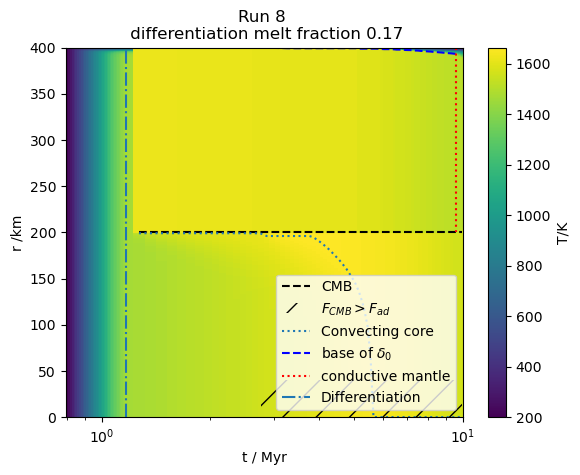

In [15]:
plt.figure()
plt.pcolormesh(t_plot_all,rplot,Tall,shading = 'nearest') # use same vmin and vmax as other plots to make them comparable
plt.hlines(rc/1e3,min(t/Myr),max(tall/Myr),linestyle='--',color='black',label='CMB')
plt.fill_betweenx([0,rc/5e3],t[np.where(Fcmb>Fad)[0]][0]/Myr,t[np.where(Fcmb>Fad)[0]][-1]/Myr,alpha=0,hatch='/',label='$F_{CMB}>F_{ad}$')
plt.plot(t/Myr,r_unstable,linestyle='dotted',label='Convecting core')
if conduction == True:
    plt.plot(t[t/Myr<=cond_t]/Myr,(r-d0[t/Myr<=cond_t])/1e3,linestyle='dashed',label='base of $\delta_0$',color='blue')
    plt.vlines(t[t/Myr<=cond_t][-1]/Myr,r/1e3,rc/1e3,linestyle='dotted',label='conductive mantle',color='red')
else:
    plt.plot(t/Myr,(r-d0)/1e3,linestyle='dashed',label='base of $\delta_0$',color='blue')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([(r-10000)/1e3,r/1e3])
plt.ylim([0,r/1e3])
plt.vlines(tdiff[-1]/Myr,0,r/1e3,linestyle='-.',label='Differentiation')
plt.colorbar(label='T/K')
plt.title(f'Run {run} \n differentiation melt fraction {(diff_T-1400)/400:.2f}')
plt.xscale('log')
plt.legend(loc='lower right')
if save == True:
    plt.savefig(f'Plots/Tall_run{run}.png')

## Melted silicate content <a class="anchor" id="silicate"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

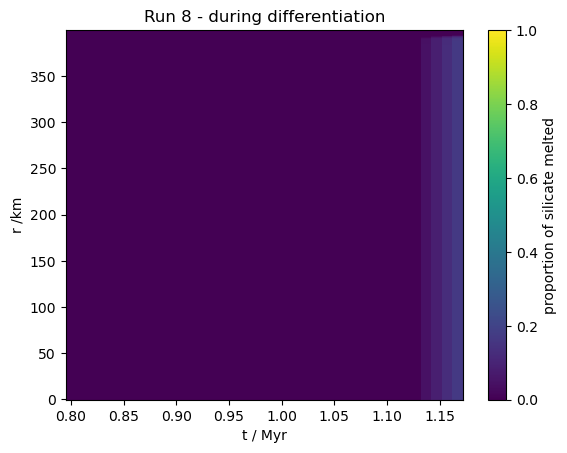

In [16]:
plt.figure()
plt.pcolormesh(tdiff/Myr, rplot,silicate_d,shading = 'nearest',vmin=0,vmax=1) # use same vmin and vmax as other plots to make them comparable
#plt.yscale('log')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([0,400])
plt.title(f'Run {run} - during differentiation')
plt.colorbar(label='proportion of silicate melted')
if save ==True:
    plt.savefig(f'Plots/si_diff_run_{run}.png')

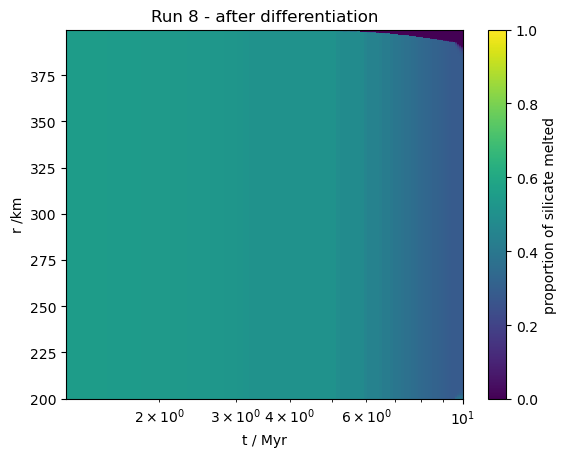

In [17]:
rmantle = np.arange(int(r/2),int(r),int(dr))/1e3
plt.figure()
plt.pcolormesh(t/Myr, rmantle,np.transpose(silicate_t),shading = 'nearest',vmin=0, vmax=1) # use same vmin and vmax as other plots to make them comparable
plt.xscale('log')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([0,400])
plt.title(f'Run {run} - after differentiation')
plt.colorbar(label='proportion of silicate melted')
if save ==True:
    plt.savefig(f'Plots/si_therm_run_{run}.png')

## Rayleigh number<a class="anchor" id="critical-rayleigh"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

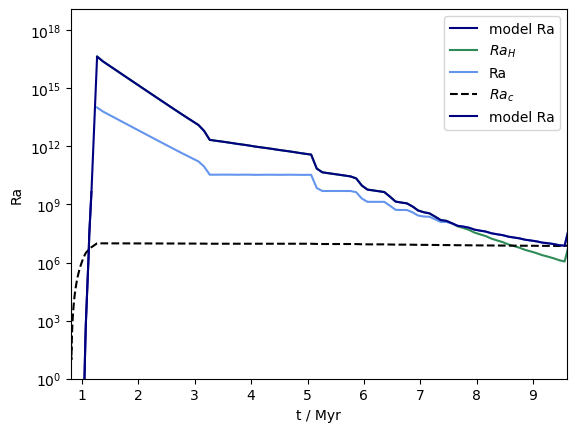

In [18]:
plt.figure()
plt.semilogy(tdiff/Myr,Ra_d,label='model Ra',color='navy')
plt.semilogy(t/Myr,RaH,label='$Ra_H$',color='seagreen')
plt.semilogy(t/Myr,RanoH,label='Ra',color='cornflowerblue')
plt.semilogy(t_plot_all,Ra_crit_all,label='$Ra_c$',linestyle='dashed',color='black') 
plt.semilogy(t_plot_all,Ra_all,label='model Ra',color='navy') 
plt.ylim(bottom=1e0)#,top=1e8)
#plt.xlim([min(tall/Myr),5])
#plt.vlines(tdiff[-1]/Myr,1e3,1e18,linestyle='dotted',color='blue',label='differentiation')
if conduction == True:
    #plt.vlines(cond_t,1e3,1e18,linestyle='dashed',color='k',label='conduction')
    plt.xlim([min(tall/Myr),cond_t])
plt.ylabel('Ra')
#plt.xscale('log')
plt.xlabel('t / Myr')
#plt.title(f'Run {run}')
plt.legend()
#if save == True:
#plt.savefig(f'Plots/Ra_run{run}.png')

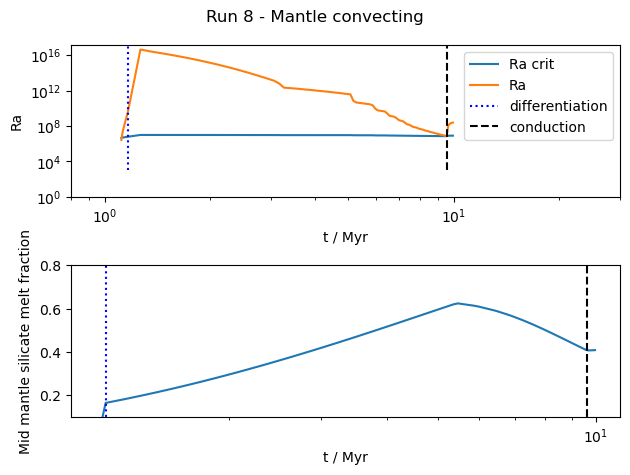

In [19]:
plt.figure(tight_layout=True)
plt.subplot(2,1,1)
plt.semilogy(t_plot_all[d0_all<r],Ra_crit_all[d0_all<r],label='Ra crit') 
plt.semilogy(t_plot_all[d0_all<r],Ra_all[d0_all<r],label='Ra') 
plt.ylim(bottom=1e0)
plt.xlim([min(tall/Myr),30])
plt.vlines(tdiff[-1]/Myr,1e3,1e25,linestyle='dotted',color='blue',label='differentiation')
if conduction == True:
    plt.vlines(cond_t,1e3,1e18,linestyle='dashed',color='k',label='conduction')
plt.ylabel('Ra')
plt.xscale('log')
plt.xlabel('t / Myr')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t_plot_all[d0_all<r],(Tall[int(nmantle/2),d0_all<r]-1400)/400)
plt.vlines(tdiff[-1]/Myr,0,0.8,linestyle='dotted',color='blue',label='differentiation')
if conduction == True:
    plt.vlines(cond_t,0,0.8,linestyle='dashed',color='k',label='conduction')
#plt.xlim([min(tall/Myr),30])
plt.ylim([0.1,0.8])
plt.xscale('log')
plt.ylabel('Mid mantle silicate melt fraction')
plt.suptitle(f'Run {run} - Mantle convecting')
plt.xlabel('t / Myr')
if save == True:
    plt.savefig(f'Plots/Ra_phi_comp_run{run}.png',dpi=300)

## Stagnant lid thickness <a class="anchor" id="d0"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

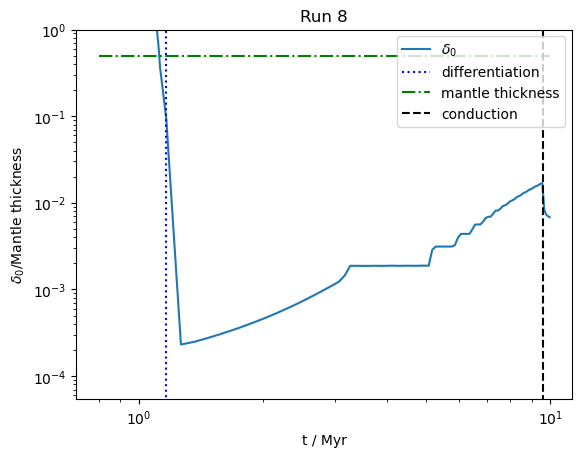

In [20]:
plt.figure()
plt.semilogy(tall/Myr,d0_all/r,label='$\delta_0$') 
plt.ylim(top=1e0)
#plt.xlim([min(tall/Myr),25])
plt.vlines(tdiff[-1]/Myr,0,1,linestyle='dotted',color='blue',label='differentiation')
plt.hlines(0.5,min(tall/Myr),max(tall/Myr),linestyle='-.',color='green',label='mantle thickness')
if conduction == True:
    plt.vlines(cond_t,0,1,linestyle='dashed',color='k',label='conduction')
plt.ylabel('$\delta_0$/Mantle thickness')
plt.xlabel('t / Myr')
plt.xscale('log')
plt.title(f'Run {run}')
plt.legend()
if save == True:
    plt.savefig(f'Plots/d0_run{run}.png')

### CMB boundary layer thickness

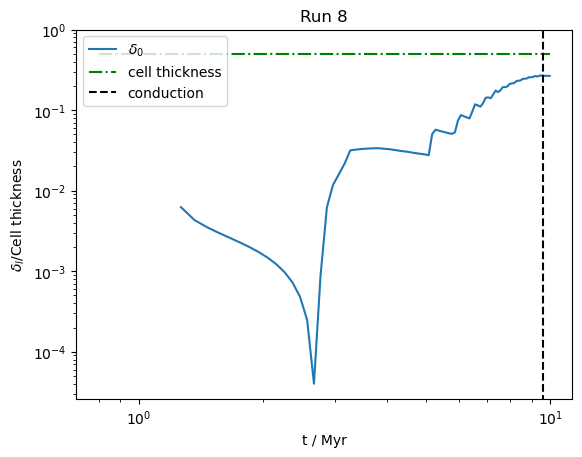

In [21]:
plt.figure()
plt.semilogy(t_plot_t,dl/dr,label='$\delta_0$') 
plt.ylim(top=1e0)
#plt.xlim([min(tall/Myr),25])
plt.hlines(0.5,min(tall/Myr),max(tall/Myr),linestyle='-.',color='green',label='cell thickness')
if conduction == True:
    plt.vlines(cond_t,0,1,linestyle='dashed',color='k',label='conduction')
plt.ylabel('$\delta_l$/Cell thickness')
plt.xlabel('t / Myr')
plt.xscale('log')
plt.title(f'Run {run}')
plt.legend()
if save == True:
    plt.savefig(f'Plots/dl_run{run}.png')

## Urey ratio  <a class="anchor" id="Urey"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

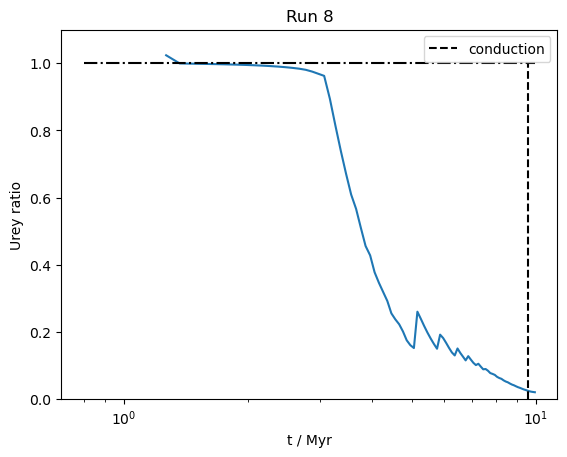

In [22]:
plt.figure()
plt.plot(t_plot_t,Urey) 
#plt.xlim([min(tall/Myr),25])
plt.hlines(1,min(tall/Myr),max(tall/Myr),linestyle='-.',color='black')
if conduction == True:
    plt.vlines(cond_t,0,1,linestyle='dashed',color='k',label='conduction')
    plt.legend()
plt.ylabel('Urey ratio')
plt.xlabel('t / Myr')
plt.xscale('log')
plt.ylim([0,1.1])
plt.title(f'Run {run}')
if save == True:
 plt.savefig(f'Plots/Urey{run}.png')

## Melted iron content during differentiation<a class="anchor" id="iron"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

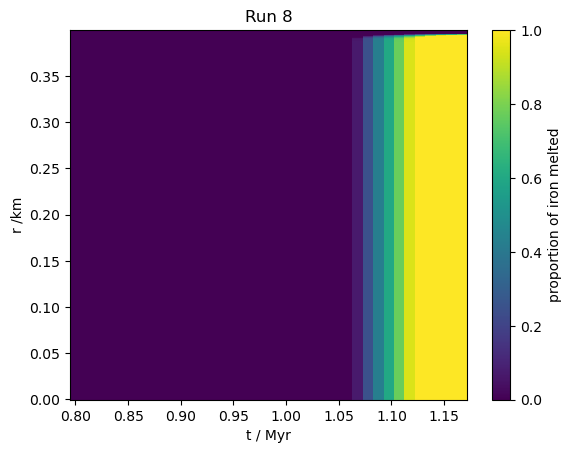

In [23]:
plt.figure()
plt.pcolormesh(tdiff/Myr, rplot/1e3,iron,shading = 'nearest') # use same vmin and vmax as other plots to make them comparable
#plt.yscale('log')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([0,400])
plt.title(f'Run {run}')
plt.colorbar(label='proportion of iron melted')
if save ==True:
    plt.savefig(f'Plots/fe_diff_run_{run}.png')

## Temperature and Flux Plot <a class="anchor" id="temp-heat"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

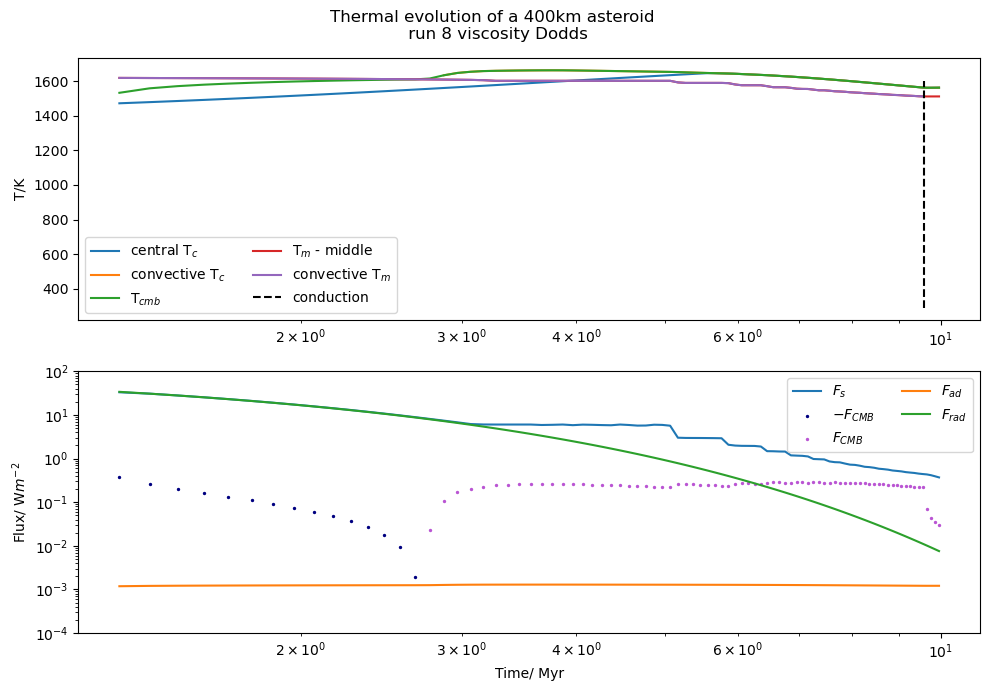

In [24]:
plt.figure(tight_layout=True,figsize=[10,7])
plt.suptitle(f'Thermal evolution of a {r/1e3:.0f}km asteroid \n run {run} viscosity {viscosity}')

xmin=tstart

#temperatures as function of time
plt.subplot(2,1,1)
if log_time == True:
    plt.semilogx(t_plot_t,Tc,label='central T$_c$')
    plt.semilogx(t_plot_t[Tc_conv!=0],Tc_conv[Tc_conv!=0],label='convective T$_c$')
    plt.semilogx(t_plot_t,Tcmb,label='T$_{cmb}$')
    plt.semilogx(t_plot_t,Tm_mid,label='T$_m$ - middle')
    plt.semilogx(t_plot_t[Tm_conv!=0],Tm_conv[Tm_conv!=0],label='convective T$_m$')
    #plt.semilogx(t_plot_t,Tm_conv,label='convective T$_m$')
    #plt.semilogx(t_plot_t,Tm_surf,label='T$_m$ - surface')
else:
    plt.plot(t_plot_t,Tc,label='central T$_c$')
    plt.plot(t_plot_t[Tc_conv!=0],Tc_conv[Tc_conv!=0],label='convective T$_c$')
    plt.plot(t_plot_t,Tcmb,label='T$_{cmb}$')
    plt.plot(t_plot_t,Tm_mid,label='T$_m$ - middle')
    plt.plot(t_plot_t[Tm_conv!=0],Tm_conv[Tm_conv!=0],label='convective T$_m$')
    #plt.plot(t_plot_t,Tm_surf,label='T$_m$ - surface')
if conduction == True:
    plt.vlines(cond_t,ymin=min(Tm_surf),ymax=1600,color='black',linestyle='--',label='conduction')
#plt.ylim([1460,1650]) #use these limits when comparing runs
plt.ylabel('T/K')
plt.legend(loc='lower left', ncol= 2)

#fluxes as function of time
plt.subplot(2,1,2)

Fcmb_neg = Fcmb[Fcmb<0]
Fcmb_pos = Fcmb[Fcmb>0]
if log_time == True:
    plt.loglog(t_plot_t,Fs,label='$F_s$')
    plt.scatter(t_plot_t[Fcmb<0],abs(Fcmb_neg),label='$-F_{CMB}$',color='navy',s=2)
    plt.scatter(t_plot_t[Fcmb>0],Fcmb_pos,label='$F_{CMB}$',color='mediumorchid',s=2)
    plt.loglog(t_plot_t,Fad,label='$F_{ad}$')
    plt.loglog(t_plot_t,Frad,label='$F_{rad}$')
else:
    plt.semilogy(t_plot_t,Fs,label='$F_s$')
    plt.scatter(t_plot_t[Fcmb<0],abs(Fcmb_neg),label='$-F_{CMB}$',color='navy',s=2)
    plt.scatter(t_plot_t[Fcmb>0],Fcmb_pos,label='$F_{CMB}$',color='mediumorchid',s=2)
    plt.semilogy(t_plot_t,Fad,label='$F_{ad}$')
    plt.semilogy(t_plot_t,Frad,label='$F_{rad}$')
plt.xlabel('Time/ Myr')

plt.ylim([1e-4,1e2])   #use these limits when comparing runs
plt.ylabel('Flux/ W$m^{-2}$')
plt.legend(loc='upper right',ncol=2)


if save == True:
    plt.savefig('Plots/run_{}_Tflux.png'.format(run),dpi=450)


## Magnetic Reynolds number and inner core size <a class="anchor" id="Rem"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

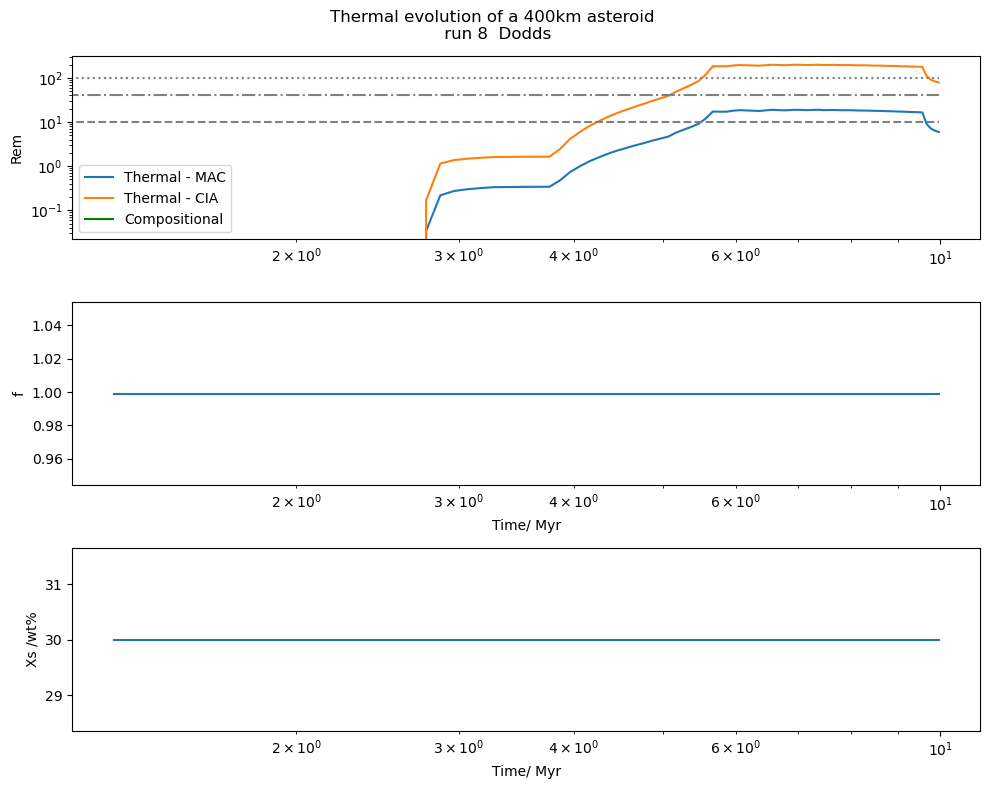

In [25]:
plt.figure(tight_layout=True,figsize=[10,8])
plt.suptitle(f'Thermal evolution of a {r/1e3:.0f}km asteroid \n run {run}  {viscosity}')
plt.subplot(3,1,1)
plt.loglog(t_plot_t,Rem_mac,label='Thermal - MAC')
plt.loglog(t_plot_t,Rem_cia,label='Thermal - CIA')
plt.loglog(t_plot_t[Rem_c!=0],Rem_c[Rem_c!=0],label='Compositional',color='green')
plt.hlines(10,xmin=0,xmax=t_plot_t[len(Rem_cia)-1],color='gray',linestyle='--')
plt.hlines(40,xmin=0,xmax=t_plot_t[len(Rem_cia)-1],color='gray',linestyle='-.')
plt.hlines(100,xmin=0,xmax=t_plot_t[len(Rem_cia)-1],color='gray',linestyle='dotted')
#plt.xlabel('Time/Myr')
plt.ylabel('Rem')
plt.legend(loc='lower left')
#plt.xscale('log')
#plt.xlim([100,200])

plt.subplot(3,1,2)
plt.plot(t_plot_t,f,label='f')
plt.xscale('log')
plt.xlabel('Time/ Myr')
plt.ylabel('f')

plt.subplot(3,1,3)
plt.plot(t_plot_t,Xs,label='Xs')
plt.xscale('log')
plt.xlabel('Time/ Myr')
plt.ylabel('Xs /wt%')


if save == True:
    plt.savefig('Plots/run_{}_Remf.png'.format(run),dpi=450)

### Time of dynamo generation

This needs tweaking to check for periods of on and off dynamo.

In [26]:
t_therm1 = t_plot_t[Rem_mac>10]
t_therm11 = t_therm1[t_therm1<100] #distinguish between early and late dynamo
t_therm12 = t_therm1[t_therm1>100]
t_therm2 = t_plot_t[Rem_cia>10]
t_therm21 = t_therm2[t_therm2<100]
t_therm22 = t_therm2[t_therm2>100]
t_comp = t_plot_t[Rem_c>10]
if np.any(Rem_mac>10):
    if np.any(t_therm1<100):
        MAC_start = t_therm11[0]
        MAC_stop = t_therm11[-1]
        print(f'MAC balance predicts there is a thermal dynamo between {MAC_start:.1f} and {MAC_stop:.1f}Myr')
    if np.any(t_therm1>100):
        MAC_start = t_therm12[0]
        MAC_stop = t_therm12[-1]
        print(f'MAC balance predicts there is a thermal dynamo between {MAC_start:.1f} and {MAC_stop:.1f}Myr')
else:
    MAC_start = np.nan
    MAC_stop = np.nan
    print('MAC balance predicts there is no thermal dynamo')
if np.any(Rem_cia>10):
    if np.any(t_therm2<100):
        CIA_start = t_therm21[0]
        CIA_stop = t_therm21[-1]
        print(f'CIA balance predicts there is a thermal dynamo between {CIA_start:.1f} and {CIA_stop:.1f}Myr')
    if np.any(t_therm2>100):
        CIA_start = t_therm22[0]
        CIA_stop = t_therm22[-1]
        print(f'CIA balance predicts there is a thermal dynamo between {CIA_start:.1f} and {CIA_stop:.1f}Myr')
else:
    CIA_start = np.nan
    CIA_stop = np.nan
    print('CIA balance predicts there is no thermal dynamo')
if np.any(Rem_c>10):
    comp_start = t_comp[0]
    comp_stop = t_comp[-1]
    print(f'There is a compositional dynamo between {comp_start:.1f} and {comp_stop:.1f} Myr')
else:
    comp_start = np.nan
    comp_stop = np.nan
    print('There is no compositional dynamo')

MAC balance predicts there is a thermal dynamo between 5.6 and 9.6Myr
CIA balance predicts there is a thermal dynamo between 4.3 and 10.0Myr
There is no compositional dynamo


## Magnetic Field Strength <a class="anchor" id="B"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [27]:
Blabel = ['B$_{flux}$ - ML','B$_{flux}$ - MAC', 'B$_{flux}$ - CIA','B$_{flux}$ comp']
Rem = np.array([Rem_mac, Rem_mac, Rem_cia,Rem_c])

Text(0.5, 1.0, 'Run 8 - field strengths for supercritical Re$_m$')

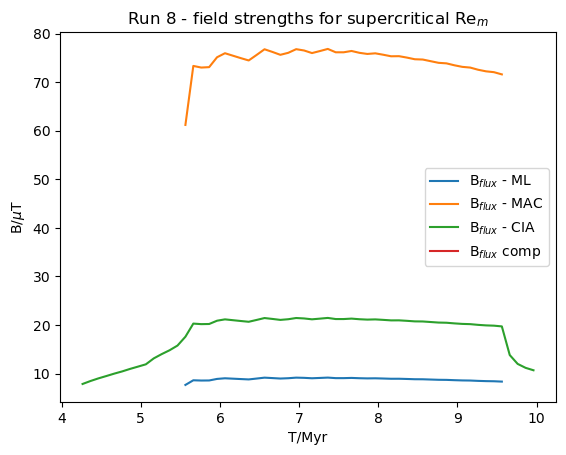

In [28]:
threshold = 10 #critical Rem
plt.figure()
for i, labels in enumerate(Blabel):
    plt.plot(t_plot_t[Rem[i,:]>threshold],B[i,Rem[i,:]>threshold]/1e-6,label=labels)
plt.legend()
plt.xlabel('T/Myr')
plt.ylabel('B/$\mu$T')
plt.title(f'Run {run} - field strengths for supercritical Re$_m$')

### Calculate max field strengths and Rem

In [29]:
m = len(Blabel)
max_B = np.zeros([m])
max_Bt = np.zeros([m])
for i in range(m):
    if np.any(Rem[i,:]>threshold):
        max_B[i] = np.max(B[i,Rem[i,:]>threshold])
        max_Bt[i] = t_plot_t[B[i,:]==max_B[i]][0]

In [30]:
max_Rem = np.zeros([m])
max_Remt = np.zeros([m])
for i in range(m):
    if np.any(Rem[i,:]>threshold):
        max_Rem[i] = np.max(Rem[i,Rem[i,:]>threshold])
        max_Remt[i] = t_plot_t[Rem[i,:]==max_Rem[i]][0]
print(f'The maximum MAC Rem is {max_Rem[0]:.2f} at {max_Remt[0]:.2f} Myr')

The maximum MAC Rem is 18.91 at 7.36 Myr


In [40]:
var_list2 = [run,tstep,dr,diff_time, diff_T, peakT, tmax, tstrat_end, 
             terode, tc_conv1, tc_conv2, cond_t, max_Rem[0], max_Remt[0], max_Rem[1], max_Remt[1], max_Rem[2], 
             max_Remt[2], max_Rem[3], max_Remt[3],MAC_start,MAC_stop, CIA_start, CIA_stop, comp_start, comp_stop,
             max_B[0],max_Bt[0],max_B[1],max_Bt[1],max_B[2],max_Bt[2],max_B[3],max_Bt[3]]
from csv import writer
with open(f'{path}timestep_test.csv','a') as f_object:
     writer_object = writer(f_object) #pass file object to csv.writer
     writer_object.writerow(var_list2) # pass list as argument into write row
     f_object.close() #close file

In [33]:
print(data)

   Unnamed: 0  Unnamed: 1  Unnamed: 2  Unnamed: 3   Unnamed: 4   Unnamed: 5  \
0           8    0.000096         500    1.166848  1466.177615  1620.063539   
1           8    0.000096         500    1.166848  1466.177615  1620.063539   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  \
0    1.266862    2.765635    5.663263    2.765635  ...   
1    1.266862    2.765635    5.663263    2.765635  ...   

                                                 Rem  \
0  [ 18.90595309  18.90595309 198.10684881  18.90...   
1  [ 18.90595309  18.90595309 198.10684881   0.  ...   

                                         Unnamed: 13 Unnamed: 14 Unnamed: 15  \
0  [7.36187253 7.36187253 7.36187253 7.36187253 0...    5.563345    9.560073   
1      [7.36187253 7.36187253 7.36187253 0.        ]    5.563345    9.560073   

   Unnamed: 16  Unnamed: 17  Unnamed: 18  Unnamed: 19  \
0     4.264408     9.959746          NaN          NaN   
1     4.264408     9.959746          NaN          NaN   

     

In [ ]:
plt.figure()
for i, labels in enumerate(Blabel):
    plt.plot(t_plot_t,B[i,:]/1e-6,label=labels)
plt.legend()
plt.xlabel('T/Myr')
plt.ylabel('B/$\mu$T')
plt.title(f'Run{run} - all times')